In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
# from config import args
from config import hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
hyperparameters = {
        "learning_rate": 0.000005,
        "epochs": 600,
        "batch_size": 32,
}

In [4]:
# step 0. Check GPUs available:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
# set device
device = tf.device('/GPU:0') if len(gpus) != 0 else tf.device('/CPU:0')

Num GPUs Available: 1
Metal device set to: Apple M1 Pro


In [5]:
# # step 1. prepare dataset
# def json2inputlabel(data_json, bands_type="spin up"):
#     _bands_type = {"spin up": "spin_up_bands",
#                    "spin down": "spin_down_bands",
#                    "soc": "soc_bands"}
#     data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
#     print(data_input_np[:,165])
#     # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
#     data_label_np = np.array([data_json["new_label"]])
#     # data_label_np = np.array([data_json["layers_num"]])

#     return data_input_np, data_label_np

# step 1. prepare dataset
debug=0
def json2inputlabel(data_json, bands_type="spin up", gamma=False):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    
#     ## Original input bands
#     data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    ## Trial: input 40*400 and take gamma point only
    data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    if gamma:
        for pts in data_json["k_labels"]:
    #         print (pts[0], pts[1])
            if pts[0] == 'G':
                if debug:
                    print (pts[0], pts[1])

    #             if pts[1] != 0:
    #                 print (f'({pts[0]}, {pts[1]}) || layers num: {data_json["layers_num"]}')
                gamma_point = pts[1]
                break


        data_input_np = data_input_np[:,gamma_point]
        if debug:
            print (f'data_input_np: {data_input_np.shape}')
        
    ## labels
    data_label_np = np.array([data_json["new_label"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|███████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 610.67it/s]


In [6]:
# train_dataset_labels = np.array(train_dataset.data_labels).reshape(900,)
# test_dataset_labels = np.array(test_dataset.data_labels).reshape(100,)

In [7]:
# idx = np.random.permutation(len(data))
# x,y = data[idx], classes[idx]

In [8]:
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

# #     tf.keras.layers.Dense(375, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

# #     tf.keras.layers.Dense(25, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]

# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(40, )),
#     tf.keras.layers.LeakyReLU(),    
    
#     tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

# #     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),


# #     tf.keras.layers.Dense(5),
#     tf.keras.layers.Dense(args["load"]["numClasses"]),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]

MLP_model = [
    tf.keras.layers.Flatten(input_shape=(40, 100)),
    tf.keras.layers.LeakyReLU(),    
    
    tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(9),
#     tf.keras.layers.Dense(args["load"]["numClasses"]),
    tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Softmax()
]

# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(40, )),
# #     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


# #     tf.keras.layers.Dense(5),
#     tf.keras.layers.Dense(args["load"]["numClasses"]),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]


# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]

In [9]:
# step 2. build model
model = tf.keras.Sequential(MLP_model)

# step 3. define loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # step 4. Model compile
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hyperparameters['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# step 5. select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
# step 6. train & evaluate & save model
losses_train, accuracy_train, losses_test, accuracy_test, model = function_training.train_it(device, model, "./state_dicts/",
                                                                                      hyperparameters['epochs'],train_loader, test_loader, loss_fn, optimizer,
                                                                                      train_loss, train_accuracy, test_loss, test_accuracy,
                                                                                      eval_num_epochs=1, numClasss=args["load"]["numClasses"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4000)              0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             40010000  
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               5000500   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 500)               0

2022-09-24 01:01:24.551431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 | Loss:   10.514729499816895 | Accuracy (%):   19.088319778442383
	Test Loss:  3.0333845615386963  |  Test Accuracy (%): 29.059829711914062
Epoch 2 | Loss:   4.181743144989014 | Accuracy (%):   23.456790924072266
	Test Loss:  2.86295223236084  |  Test Accuracy (%): 28.205129623413086
Epoch 3 | Loss:   3.213507890701294 | Accuracy (%):   28.300094604492188
	Test Loss:  2.525725841522217  |  Test Accuracy (%): 23.931625366210938
Epoch 4 | Loss:   2.865466356277466 | Accuracy (%):   29.439697265625
	Test Loss:  2.564356565475464  |  Test Accuracy (%): 30.76923179626465
Epoch 5 | Loss:   2.722346544265747 | Accuracy (%):   31.339031219482422
	Test Loss:  2.281794548034668  |  Test Accuracy (%): 33.333335876464844
Epoch 6 | Loss:   2.478131055831909 | Accuracy (%):   34.09307098388672
	Test Loss:  2.1639773845672607  |  Test Accuracy (%): 28.205129623413086
Epoch 7 | Loss:   2.4265878200531006 | Accuracy (%):   30.57929801940918
	Test Loss:  2.15571928024292  |  Test Accuracy (%): 2

Epoch 57 | Loss:   1.853988766670227 | Accuracy (%):   36.46723556518555
	Test Loss:  1.8821806907653809  |  Test Accuracy (%): 29.914531707763672
Epoch 58 | Loss:   1.8682806491851807 | Accuracy (%):   35.13770294189453
	Test Loss:  1.8580408096313477  |  Test Accuracy (%): 33.333335876464844
Epoch 59 | Loss:   1.911700963973999 | Accuracy (%):   35.0427360534668
	Test Loss:  2.0130410194396973  |  Test Accuracy (%): 33.333335876464844
Epoch 60 | Loss:   1.8236970901489258 | Accuracy (%):   35.32763671875
	Test Loss:  2.2192282676696777  |  Test Accuracy (%): 29.059829711914062
Epoch 61 | Loss:   1.860990047454834 | Accuracy (%):   37.41690444946289
	Test Loss:  2.1405489444732666  |  Test Accuracy (%): 29.059829711914062
Epoch 62 | Loss:   1.8983256816864014 | Accuracy (%):   35.232669830322266
	Test Loss:  1.8984730243682861  |  Test Accuracy (%): 29.914531707763672
Epoch 63 | Loss:   1.8491168022155762 | Accuracy (%):   35.70750427246094
	Test Loss:  1.8756968975067139  |  Test Acc

Epoch 113 | Loss:   1.7334734201431274 | Accuracy (%):   38.2716064453125
	Test Loss:  1.8502434492111206  |  Test Accuracy (%): 26.4957275390625
Epoch 114 | Loss:   1.7597099542617798 | Accuracy (%):   38.46154022216797
	Test Loss:  1.768336534500122  |  Test Accuracy (%): 36.75213623046875
Epoch 115 | Loss:   1.7237260341644287 | Accuracy (%):   38.176639556884766
	Test Loss:  1.8675086498260498  |  Test Accuracy (%): 35.0427360534668
Epoch 116 | Loss:   1.801893711090088 | Accuracy (%):   35.32763671875
	Test Loss:  2.0109548568725586  |  Test Accuracy (%): 34.18803405761719
Epoch 117 | Loss:   1.8020647764205933 | Accuracy (%):   39.031341552734375
	Test Loss:  1.7523187398910522  |  Test Accuracy (%): 41.0256462097168
Epoch 118 | Loss:   1.771226406097412 | Accuracy (%):   36.65717315673828
	Test Loss:  1.9097692966461182  |  Test Accuracy (%): 26.4957275390625
Epoch 119 | Loss:   1.77806556224823 | Accuracy (%):   36.65717315673828
	Test Loss:  1.8199573755264282  |  Test Accurac

Epoch 169 | Loss:   1.7313597202301025 | Accuracy (%):   37.32194137573242
	Test Loss:  1.8220361471176147  |  Test Accuracy (%): 29.914531707763672
Epoch 170 | Loss:   1.6966521739959717 | Accuracy (%):   37.511871337890625
	Test Loss:  1.8575773239135742  |  Test Accuracy (%): 35.0427360534668
Epoch 171 | Loss:   1.6776115894317627 | Accuracy (%):   38.74644088745117
	Test Loss:  1.8592395782470703  |  Test Accuracy (%): 26.4957275390625
Epoch 172 | Loss:   1.6526334285736084 | Accuracy (%):   39.221275329589844
	Test Loss:  1.8159825801849365  |  Test Accuracy (%): 36.75213623046875
Epoch 173 | Loss:   1.7036869525909424 | Accuracy (%):   36.65717315673828
	Test Loss:  1.8739042282104492  |  Test Accuracy (%): 32.478633880615234
Epoch 174 | Loss:   1.765563726425171 | Accuracy (%):   38.84140396118164
	Test Loss:  1.9913338422775269  |  Test Accuracy (%): 30.76923179626465
Epoch 175 | Loss:   1.7215505838394165 | Accuracy (%):   38.84140396118164
	Test Loss:  1.8520698547363281  |  

Epoch 225 | Loss:   1.6769382953643799 | Accuracy (%):   39.031341552734375
	Test Loss:  1.8698476552963257  |  Test Accuracy (%): 35.0427360534668
Epoch 226 | Loss:   1.6522862911224365 | Accuracy (%):   38.65147399902344
	Test Loss:  1.8950870037078857  |  Test Accuracy (%): 27.35042953491211
Epoch 227 | Loss:   1.67225182056427 | Accuracy (%):   38.93637466430664
	Test Loss:  2.0182228088378906  |  Test Accuracy (%): 35.0427360534668
Epoch 228 | Loss:   1.6644927263259888 | Accuracy (%):   37.89173889160156
	Test Loss:  1.9081199169158936  |  Test Accuracy (%): 31.623931884765625
Epoch 229 | Loss:   1.5956664085388184 | Accuracy (%):   40.83570861816406
	Test Loss:  1.7898602485656738  |  Test Accuracy (%): 32.478633880615234
Epoch 230 | Loss:   1.624744176864624 | Accuracy (%):   40.645774841308594
	Test Loss:  1.8440495729446411  |  Test Accuracy (%): 29.914531707763672
Epoch 231 | Loss:   1.6613115072250366 | Accuracy (%):   39.98100662231445
	Test Loss:  1.794345736503601  |  Te

Epoch 281 | Loss:   1.640163540840149 | Accuracy (%):   39.50617218017578
	Test Loss:  1.724055528640747  |  Test Accuracy (%): 35.897438049316406
Epoch 282 | Loss:   1.6183326244354248 | Accuracy (%):   39.98100662231445
	Test Loss:  1.8791816234588623  |  Test Accuracy (%): 35.897438049316406
Epoch 283 | Loss:   1.7149076461791992 | Accuracy (%):   37.701805114746094
	Test Loss:  1.912721037864685  |  Test Accuracy (%): 33.333335876464844
Epoch 284 | Loss:   1.656110167503357 | Accuracy (%):   39.221275329589844
	Test Loss:  1.8646305799484253  |  Test Accuracy (%): 32.478633880615234
Epoch 285 | Loss:   1.641573190689087 | Accuracy (%):   41.120609283447266
	Test Loss:  1.737280249595642  |  Test Accuracy (%): 38.46154022216797
Epoch 286 | Loss:   1.6480519771575928 | Accuracy (%):   41.40550994873047
	Test Loss:  1.7624495029449463  |  Test Accuracy (%): 40.17094039916992
Epoch 287 | Loss:   1.6074944734573364 | Accuracy (%):   40.17094039916992
	Test Loss:  1.8315922021865845  |  

Epoch 337 | Loss:   1.5781030654907227 | Accuracy (%):   40.645774841308594
	Test Loss:  1.776004672050476  |  Test Accuracy (%): 32.478633880615234
Epoch 338 | Loss:   1.577797293663025 | Accuracy (%):   41.40550994873047
	Test Loss:  1.7496273517608643  |  Test Accuracy (%): 35.0427360534668
Epoch 339 | Loss:   1.6438144445419312 | Accuracy (%):   38.93637466430664
	Test Loss:  1.8186219930648804  |  Test Accuracy (%): 35.0427360534668
Epoch 340 | Loss:   1.6368857622146606 | Accuracy (%):   40.74074172973633
	Test Loss:  1.7724148035049438  |  Test Accuracy (%): 39.31623840332031
Epoch 341 | Loss:   1.5866219997406006 | Accuracy (%):   41.69041061401367
	Test Loss:  1.7450345754623413  |  Test Accuracy (%): 38.46154022216797
Epoch 342 | Loss:   1.592474341392517 | Accuracy (%):   42.35517501831055
	Test Loss:  1.8401403427124023  |  Test Accuracy (%): 30.76923179626465
Epoch 343 | Loss:   1.618387222290039 | Accuracy (%):   41.69041061401367
	Test Loss:  1.745856761932373  |  Test A

Epoch 393 | Loss:   1.5791808366775513 | Accuracy (%):   41.5004768371582
	Test Loss:  1.8030725717544556  |  Test Accuracy (%): 34.18803405761719
Epoch 394 | Loss:   1.5589497089385986 | Accuracy (%):   42.165245056152344
	Test Loss:  1.7848007678985596  |  Test Accuracy (%): 40.17094039916992
Epoch 395 | Loss:   1.5683997869491577 | Accuracy (%):   41.69041061401367
	Test Loss:  1.78493070602417  |  Test Accuracy (%): 37.60683822631836
Epoch 396 | Loss:   1.5839639902114868 | Accuracy (%):   42.35517501831055
	Test Loss:  1.749237060546875  |  Test Accuracy (%): 29.059829711914062
Epoch 397 | Loss:   1.5794024467468262 | Accuracy (%):   41.310543060302734
	Test Loss:  1.7734514474868774  |  Test Accuracy (%): 40.17094039916992
Epoch 398 | Loss:   1.5780876874923706 | Accuracy (%):   41.785377502441406
	Test Loss:  1.7503904104232788  |  Test Accuracy (%): 35.0427360534668
Epoch 399 | Loss:   1.5972256660461426 | Accuracy (%):   41.5004768371582
	Test Loss:  1.7617050409317017  |  Tes

Epoch 449 | Loss:   1.5401719808578491 | Accuracy (%):   46.05887985229492
	Test Loss:  1.752751350402832  |  Test Accuracy (%): 34.18803405761719
Epoch 450 | Loss:   1.573453426361084 | Accuracy (%):   43.8746452331543
	Test Loss:  1.7006425857543945  |  Test Accuracy (%): 36.75213623046875
Epoch 451 | Loss:   1.5597513914108276 | Accuracy (%):   42.165245056152344
	Test Loss:  1.786895513534546  |  Test Accuracy (%): 34.18803405761719
Epoch 452 | Loss:   1.5914084911346436 | Accuracy (%):   41.5004768371582
	Test Loss:  1.7138123512268066  |  Test Accuracy (%): 43.58974838256836
Epoch 453 | Loss:   1.565355896949768 | Accuracy (%):   41.880340576171875
	Test Loss:  1.7667323350906372  |  Test Accuracy (%): 38.46154022216797
Epoch 454 | Loss:   1.590636134147644 | Accuracy (%):   41.785377502441406
	Test Loss:  1.7332713603973389  |  Test Accuracy (%): 33.333335876464844
Epoch 455 | Loss:   1.53474760055542 | Accuracy (%):   43.399810791015625
	Test Loss:  1.7862995862960815  |  Test 

Epoch 505 | Loss:   1.5263336896896362 | Accuracy (%):   44.34947967529297
	Test Loss:  1.6837435960769653  |  Test Accuracy (%): 41.88034439086914
Epoch 506 | Loss:   1.5113290548324585 | Accuracy (%):   44.064579010009766
	Test Loss:  1.6864173412322998  |  Test Accuracy (%): 38.46154022216797
Epoch 507 | Loss:   1.5066553354263306 | Accuracy (%):   44.064579010009766
	Test Loss:  1.7793993949890137  |  Test Accuracy (%): 35.0427360534668
Epoch 508 | Loss:   1.5408333539962769 | Accuracy (%):   41.69041061401367
	Test Loss:  1.782405138015747  |  Test Accuracy (%): 37.60683822631836
Epoch 509 | Loss:   1.527569055557251 | Accuracy (%):   42.92497634887695
	Test Loss:  1.7093992233276367  |  Test Accuracy (%): 41.0256462097168
Epoch 510 | Loss:   1.541734218597412 | Accuracy (%):   41.5004768371582
	Test Loss:  1.746789813041687  |  Test Accuracy (%): 38.46154022216797
Epoch 511 | Loss:   1.5247342586517334 | Accuracy (%):   42.545108795166016
	Test Loss:  1.7331006526947021  |  Test 

Epoch 561 | Loss:   1.5278011560440063 | Accuracy (%):   42.92497634887695
	Test Loss:  1.7044553756713867  |  Test Accuracy (%): 35.897438049316406
Epoch 562 | Loss:   1.5417592525482178 | Accuracy (%):   42.070274353027344
	Test Loss:  1.757340908050537  |  Test Accuracy (%): 41.0256462097168
Epoch 563 | Loss:   1.505652904510498 | Accuracy (%):   44.34947967529297
	Test Loss:  1.7227084636688232  |  Test Accuracy (%): 39.31623840332031
Epoch 564 | Loss:   1.5121387243270874 | Accuracy (%):   42.26021194458008
	Test Loss:  1.736112117767334  |  Test Accuracy (%): 41.0256462097168
Epoch 565 | Loss:   1.5195789337158203 | Accuracy (%):   44.34947967529297
	Test Loss:  1.7787590026855469  |  Test Accuracy (%): 39.31623840332031
Epoch 566 | Loss:   1.5222864151000977 | Accuracy (%):   43.8746452331543
	Test Loss:  1.7737282514572144  |  Test Accuracy (%): 41.0256462097168
Epoch 567 | Loss:   1.513029932975769 | Accuracy (%):   42.640079498291016
	Test Loss:  1.7192492485046387  |  Test A

2022-09-24 01:08:13.194489: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./state_dicts/assets


In [11]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])
    predict = np.argmax(model.predict(element), axis=-1)
    label = np.array(labels).flatten()
#     print (f"model {model.predict_classes(element)}, actual {labels}")
#     model.predict_classes(element)
    break


In [12]:
# m = tf.keras.metrics.Accuracy()
# m.update_state(label, predict)
# m.result().numpy()


from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=label, y_pred=predict)
mse

0.358974358974359

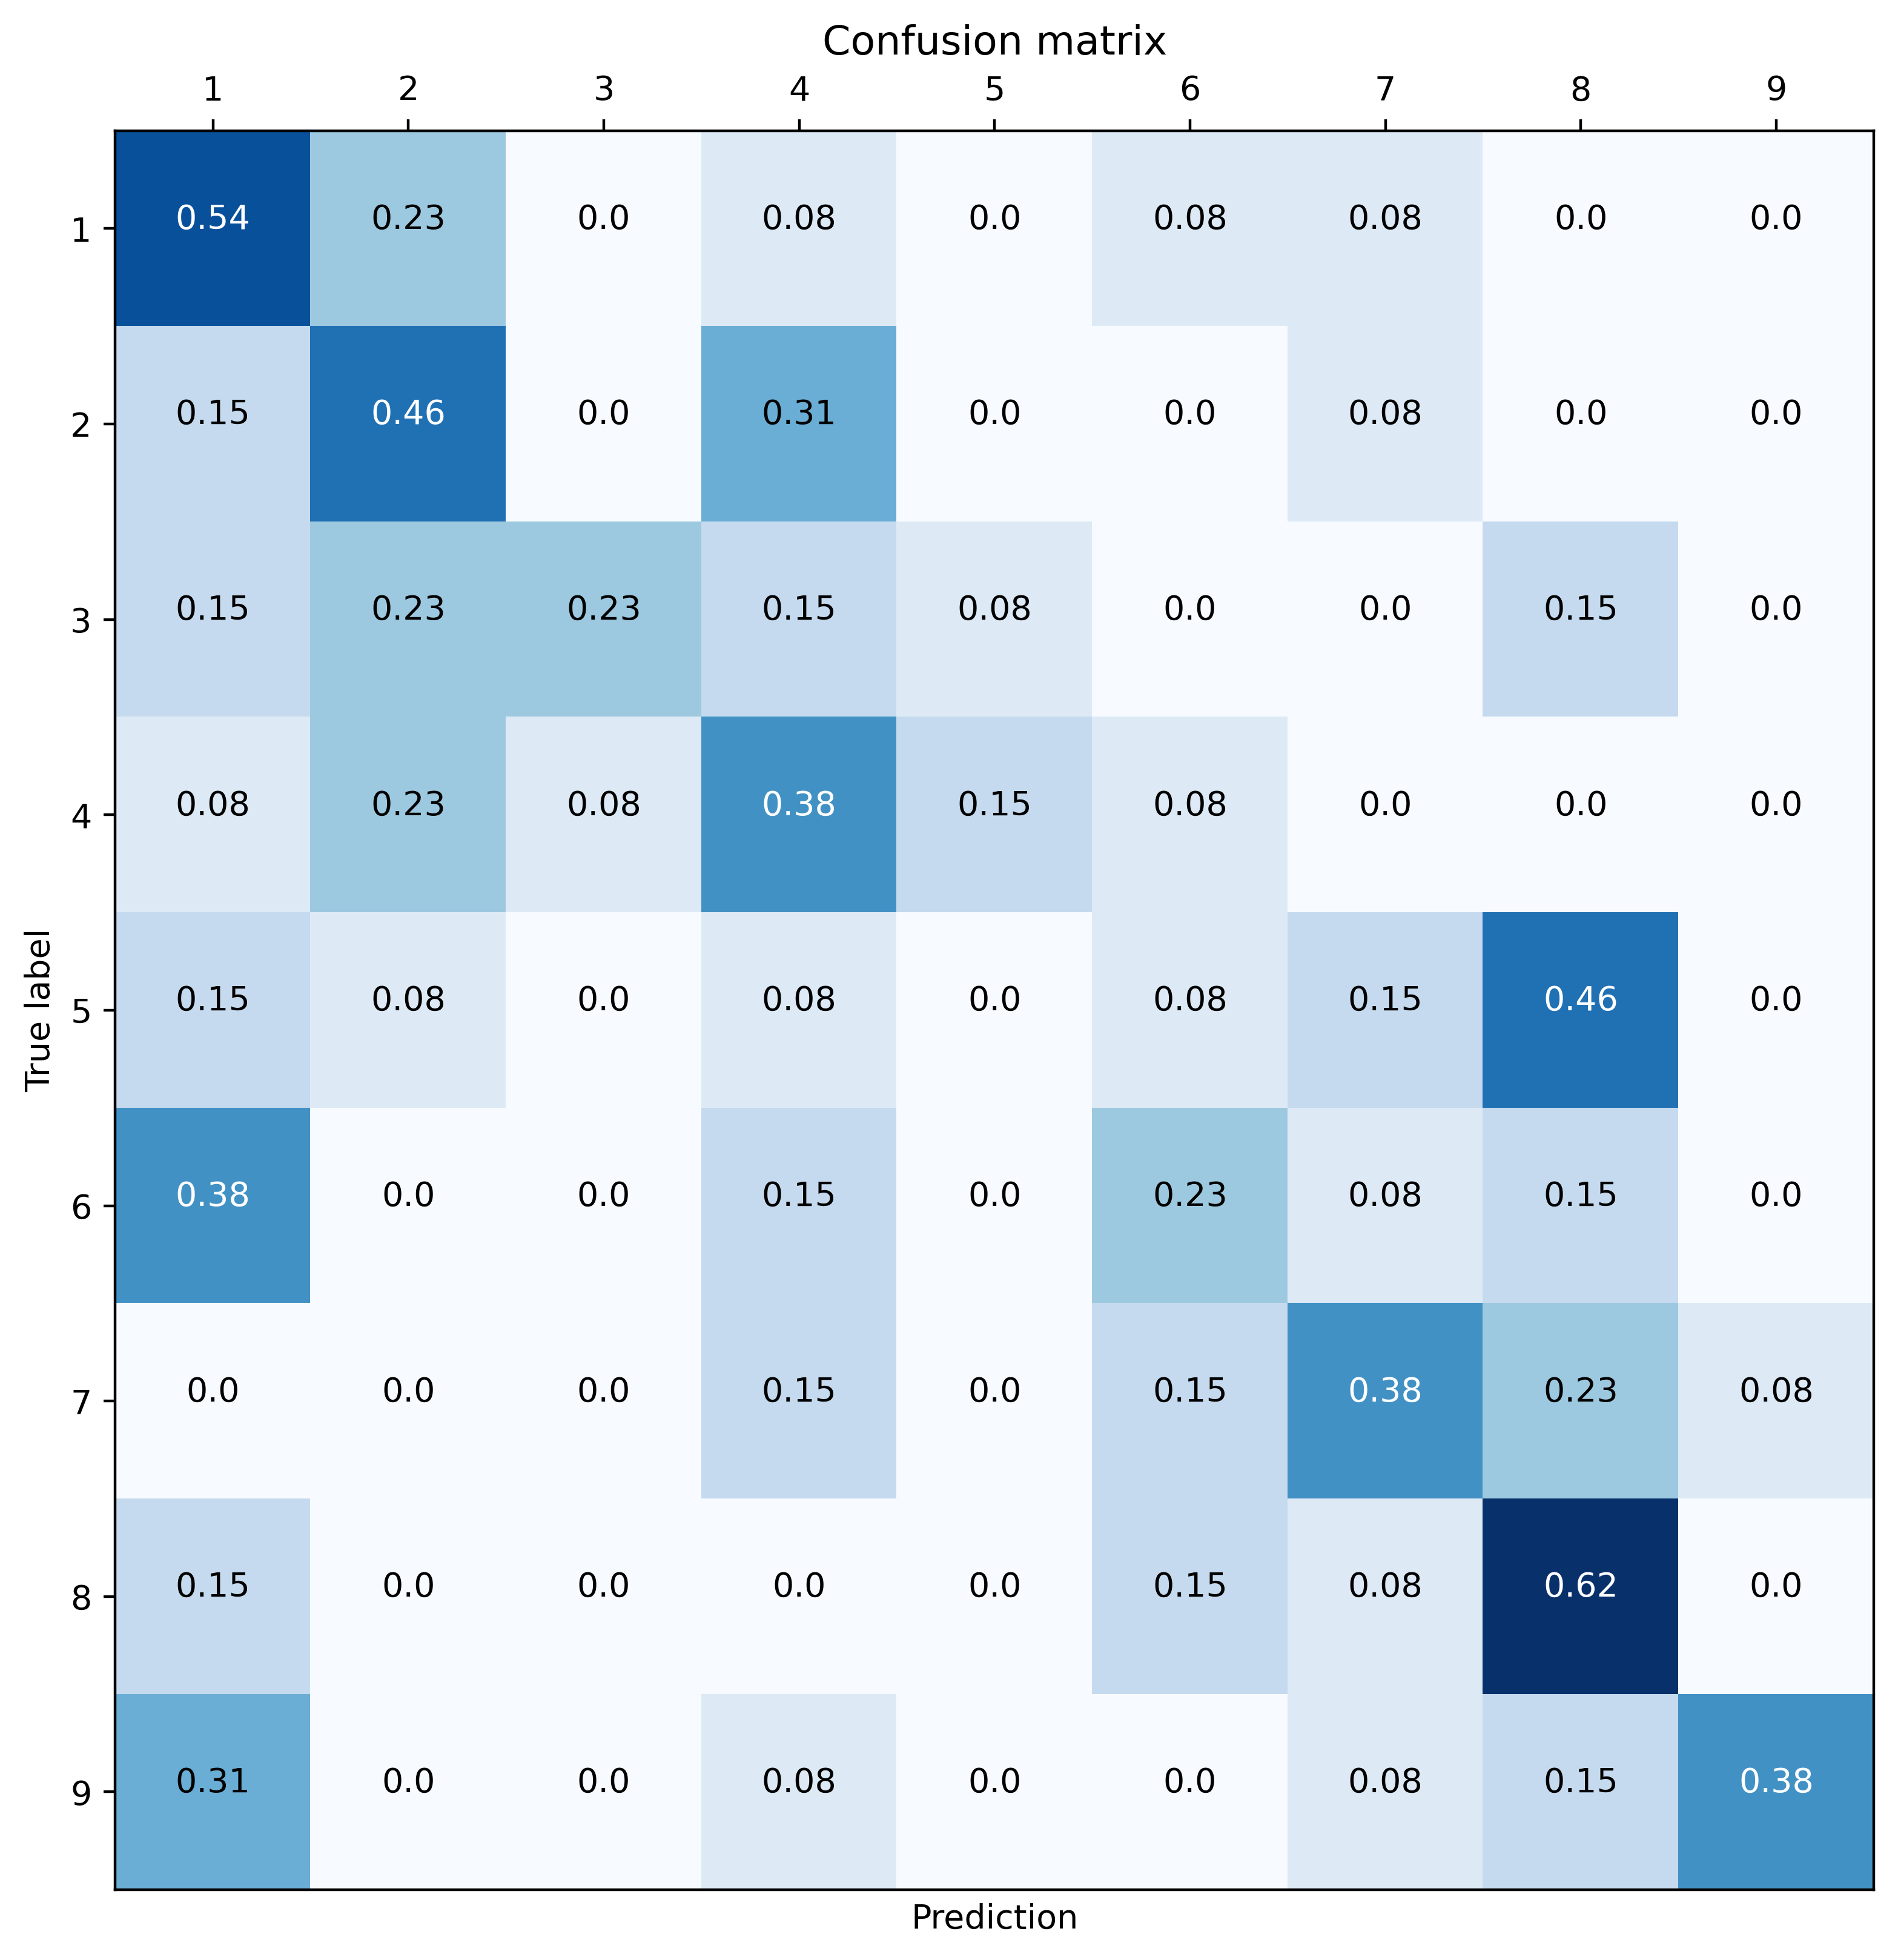

In [13]:
# confusion_matrix(labels=label, predictions=predict, class_names=[3, 4, 5, 6, 7])
confusion_matrix(labels=label, predictions=predict, class_names=np.arange(1,10,1).tolist())